In [11]:
import pandas as pd

# Load the customer summary dataset
df = pd.read_csv("C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/customer_summary.csv")

# Quick check
print(df.shape)
df.head()

(1000, 16)


,customer_id,customer_name,industry,segment,country,city,region,subregion,recency_days,frequency,monetary,total_quantity,total_profit,total_discount,tenure_days,churn_flag
0,1001,Abbott Laboratories,Healthcare,Enterprise,Australia,Sydney,APJ,ANZ,1564,1,213.12,5,-15.22,0.3,0,1
1,1001,Abbott Laboratories,Healthcare,Enterprise,Brazil,São Paulo,AMER,LATAM,1381,1,299.90,2,74.98,0.0,0,1
2,1001,Abbott Laboratories,Healthcare,Enterprise,Canada,Toronto,AMER,NAMER,873,1,425.06,20,24.32,0.2,0,1
3,1001,Abbott Laboratories,Healthcare,Enterprise,Chile,Santiago,AMER,LATAM,1553,1,191.97,7,16.80,0.2,0,1
4,1001,Abbott Laboratories,Healthcare,Enterprise,China,Shenzhen,APJ,APAC,676,1,19.98,1,8.59,0.0,0,1


In [13]:
# Let's check recency distribution
print(df['recency_days'].describe())

count    1000.000000
mean     1123.646000
std       412.167112
min       589.000000
25%       743.000000
50%      1035.000000
75%      1443.500000
max      2040.000000
Name: recency_days, dtype: float64


In [15]:
# Define churn based on median split
threshold = df['recency_days'].median()
df['churn_flag'] = df['recency_days'].apply(lambda x: 1 if x > threshold else 0)


In [17]:
# Check balance
print("Churn flag distribution:\n", df['churn_flag'].value_counts())

Churn flag distribution:
 churn_flag
0    501
1    499
Name: count, dtype: int64


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop(columns=['customer_id', 'customer_name', 'churn_flag'])
y = df['churn_flag']

categorical_cols = ['industry', 'segment', 'country', 'city', 'region', 'subregion']
categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# Function to replace rare/unseen categories with 'Other'
def replace_rare_categories(train, test, cols, threshold=0.01):
    for col in cols:
        counts = train[col].value_counts(normalize=True)
        rare_categories = counts[counts < threshold].index
        train[col] = train[col].replace(rare_categories, 'Other')
        test[col] = test[col].apply(lambda x: x if x in train[col].values else 'Other')
    return train, test

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Replace rare/unseen categories with 'Other'
X_train, X_test = replace_rare_categories(X_train, X_test, categorical_cols)

print("Train distribution:\n", y_train.value_counts())
print("Test distribution:\n", y_test.value_counts())

Train distribution:
 churn_flag
0    401
1    399
Name: count, dtype: int64
Test distribution:
 churn_flag
1    100
0    100
Name: count, dtype: int64


In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)  # no need for handle_unknown now
])

# Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

# Train the model
rf_pipeline.fit(X_train, y_train)
print("Random Forest trained successfully!")


Random Forest trained successfully!


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



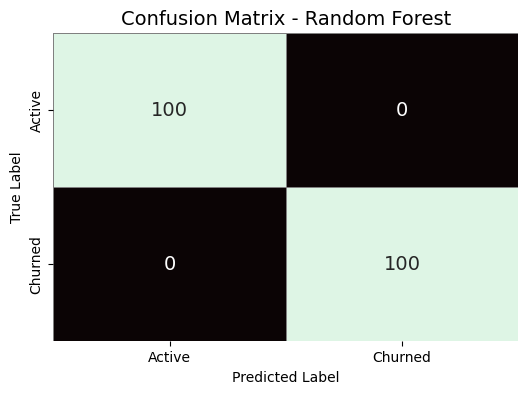

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = rf_pipeline.predict(X_test)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.figure(figsize=(6,4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="mako",
    xticklabels=["Active","Churned"], yticklabels=["Active","Churned"],
    cbar=False, linewidths=0.5, linecolor="gray", annot_kws={"size":14}
)
plt.title("Confusion Matrix - Random Forest", fontsize=14)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


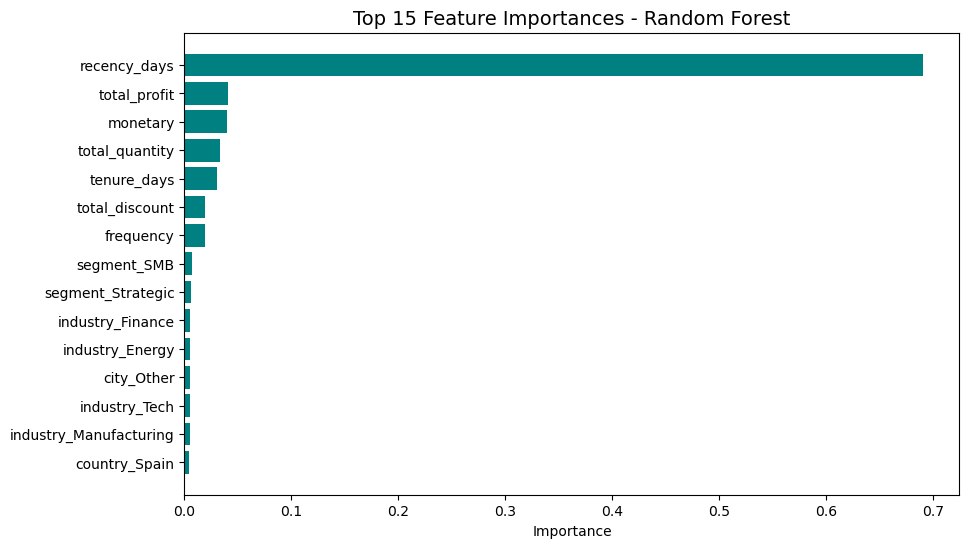

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names after preprocessing
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numeric_cols, ohe_features])

# Get feature importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot top 15 features
plt.figure(figsize=(10,6))
plt.title("Top 15 Feature Importances - Random Forest", fontsize=14)
plt.barh(range(15), importances[indices[:15]][::-1], color='teal')
plt.yticks(range(15), [feature_names[i] for i in indices[:15]][::-1])
plt.xlabel("Importance")
plt.show()


In [27]:
# Add predictions to X_test
X_test_copy = X_test.copy()
X_test_copy['actual_churn'] = y_test.values
X_test_copy['predicted_churn'] = y_pred

# Save to CSV for Power BI
X_test_copy.to_csv("predicted_churn_profiles.csv", index=False)
print("Predictions saved for Power BI!")


Predictions saved for Power BI!


In [29]:
# after model is trained
probs = rf_pipeline.predict_proba(X_test)[:,1]   # probability of churn
X_test_copy['predicted_proba'] = probs
X_test_copy.to_csv('predicted_churn_profiles.csv', index=False)


In [31]:
import os
print(os.getcwd())


C:\Users\whynew.in
